# 4-1. Image compression and Reconstruction via PCA


- 기수: 14기

- 이름: 조재우

- 작성자: 13기 강승우


_본 과제는 11기, 12기 Machine Learning과제를 참고하였음을 밝힙니다._


PCA는 고차원 데이터의 특징을 최대한 보존하면서 차원을 낮추기 위한 방법인 Dimensionality Reduction의 대표적인 method 중 하나입니다.

PCA는 결과적으로 원본 데이터의 Variance를 최대한 보존할 수 있는 Principal Component들을 찾는 것을 목표로 합니다. 그리고 선정한 Principal Component들은 모두 일정한 Explained Variance를 갖게 됩니다.

각 Principal Component의 설명력은 Covariance의 관점에서 PCA를 살펴보면 알 수 있습니다.

결국 Covariance Matrix에 대한 Eigenvalue Decomposition을 수행한 결과로써 PCA를 해석할 수 있는데, 이때 설명력이 높은 순서는 Eigenvalue의 크기가 큰 순서와 동일합니다.

본 과제 문제에서는 이러한 PCA의 간단한 구현과 Explained Variance 시각화에 대한 내용, 그리고 더 나아가 Reconstruction Error를 기반으로 한 간단한 Classification Task를 다룹니다.


## 1. Introduction: What is Reconstruction Error?


- **PCA Reconstruction은 어떻게 이루어지나요?**


<hr/>

Reduction을 거친 축소된 차원에서 다시 Principal Component를 사용한다면 원본 데이터를 복원할 수 있습니다. (PCA의 역연산)

그렇다면 Principal Component의 개수가 많을수록, 손실된 정보량이 적기 때문에 더욱 완벽한 원본 이미지를 복원할 수 있겠죠?


- **Reconstruction Error란 PCA를 이용한 Dimensionality Reduction 이후 다시 Dimension을 원래대로 Reconstruction하는 과정에서 발생하는 오차를 의미합니다.**


<hr/>

Dimensionality Reduction은 결국 정보량의 손실 (압축) 입니다. 아무리 Variance가 높게 Principal Component를 잘 설정한다 하더라도 정보량의 손실은 불가피합니다.

784차원의 데이터에 PCA를 적용하면서 Principal Component의 개수 $N$ 을 $10, 100, 250$ 각각으로 설정함에 따라 축소된 차원에서 보존되는 정보량이 늘어나게 됩니다.

또한 $N = 784$ 로 설정하게 되면 PCA를 진행하더라도, Dimension은 축소되지 않으며, 곧 정보량 또한 손실되지 않습니다.


- **그렇다면 고양이에 대한 데이터들에 대해 구한 Principal Component로 오토바이의 사진을 복원한다면 어떻게 될까요?**


<hr/>

간단하게 오토바이와 고양이의 사진들로 구성된 데이터셋이 있다고 가정해봅시다. 고양이들의 사진을 기준으로 PCA를 진행하기 위해 Principal Component를 구했습니다.

동일한 Principal Component로 오토바이 사진에 대해 Dimensionality Reduction과 Reconstruction을 진행한다면 어떻게 될까요?


- **당연히 Reconstruction Error는 오토바이 사진보다 고양이 사진에서 훨씬 더 낮을 것입니다!**


## 2. Load Dataset


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 3. Basic PCA


본 문제에서는 PCA 라이브러리가 아닌, 행렬 단위 연산을 통해 PCA 함수를 직접 구현하고자 합니다.

<hr/>


In [46]:
# PCA Function
def compute_pca(X, n_components):  # n_components: Number of Principal Component
    """
    Performs Principal Component Analysis (PCA) on the input data X.

    Parameters:
    - X: A numpy array of shape (N, F), where N is the number of samples and F is the number of features.
    - n_components: An integer specifying the number of principal components to retain.

    Returns:
    - selected_eigenvectors: A numpy array of shape (F, n_components), containing the top principal components as columns.
    - explained_variance: A numpy array of shape (n_components,), showing the explained variance ratio for the selected components.
    """
    selected_eigenvectors = np.zeros((X.shape[1], n_components))
    explained_variance = np.zeros(n_components)
    covariance_matrix = np.cov(X.T)
    ###############
    ###############

    #### TO DO ####
    # Hint1: np.linalg.eigh
    # Hint2: 위의 함수를 통해 고윳값 분해를 하면, eigenvalues와 eigenvectors가 나오는데,
    # 여기서 eigenvalues들은 오름차순이나 내림차순이 아닙니다. 따라서 np.argsort 같은 함수를 통해 sorting을 해야합니다.

    ###############
    ##
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    selected_eigenvectors = sorted_eigenvectors[:, :n_components]

    total_variance = np.sum(eigenvalues)
    explained_variance = sorted_eigenvalues[:n_components] / total_variance


    return selected_eigenvectors, explained_variance

In [47]:
def plot_pca_recon(img_path = 'tralla.jpg', components_list = [5,10,50]):
    img_path = "/content/drive/MyDrive/Colab Notebooks/DSL/HW/tralla.jpg"    # 실제 경로로 변경
    img = Image.open(img_path).convert("L")  # 흑백 변환
    W, H = img.size

    # 단일 샘플 형태로 변환
    X = np.array(img) # (H, W)

    components_list = components_list

    fig, axes = plt.subplots(1, 1 + len(components_list), figsize=(5*(1+len(components_list)), 5))

    axes[0].imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')

    #### TO DO : fill in the missing parts ####
    # Hint: compute_pca 함수를 사용하여 PCA를 수행하고, 각 n_components에 대해 재구성된 이미지를 생성합니다.
    for i, n in enumerate(components_list, start=1):
        comps, explained_variance_temp = compute_pca(X, n)
        if i == len(components_list):
            explained_variance = explained_variance_temp    # 마지막 n_components는 설명된 분산도 반환
        X_proj  = X @ comps                          # Hint : (H, n)
        X_recon = X_proj @ comps.T                          # Hint : (H, W)

        axes[i].imshow(X_recon, cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f'PC = {n}')
        axes[i].axis('off')
    ############################################

    plt.tight_layout()
    plt.show()


    return explained_variance

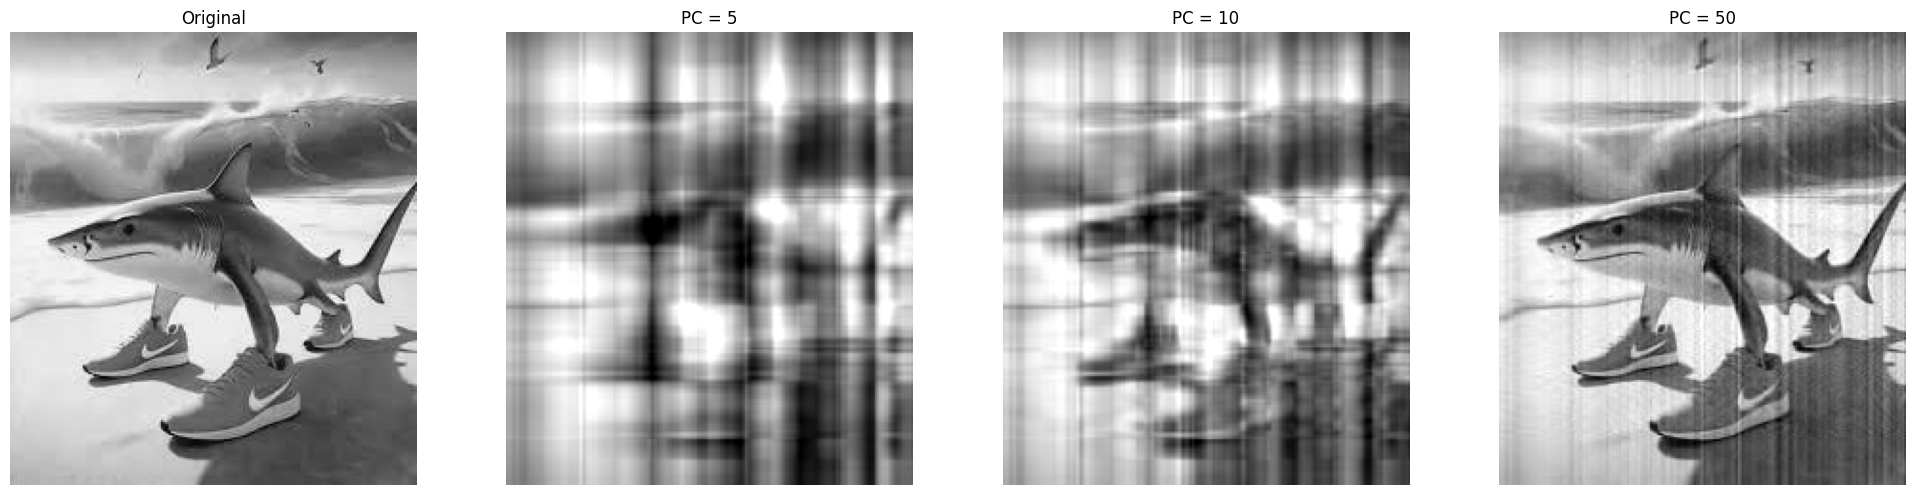

In [48]:
explained_variance = plot_pca_recon()

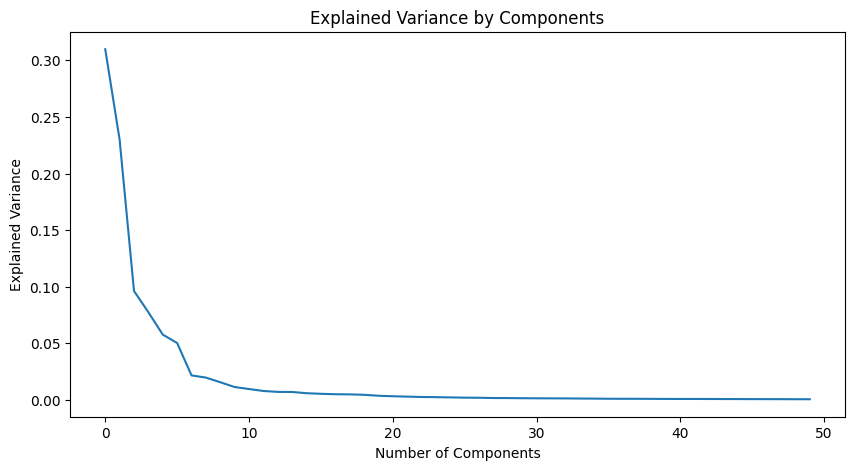

In [49]:
plt.figure(figsize = (10, 5))
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

**작성한 함수 plot_pca_recon의 입력 이미지와 주성분 개수 리스트를 바꿔가며 실험해보세요!**


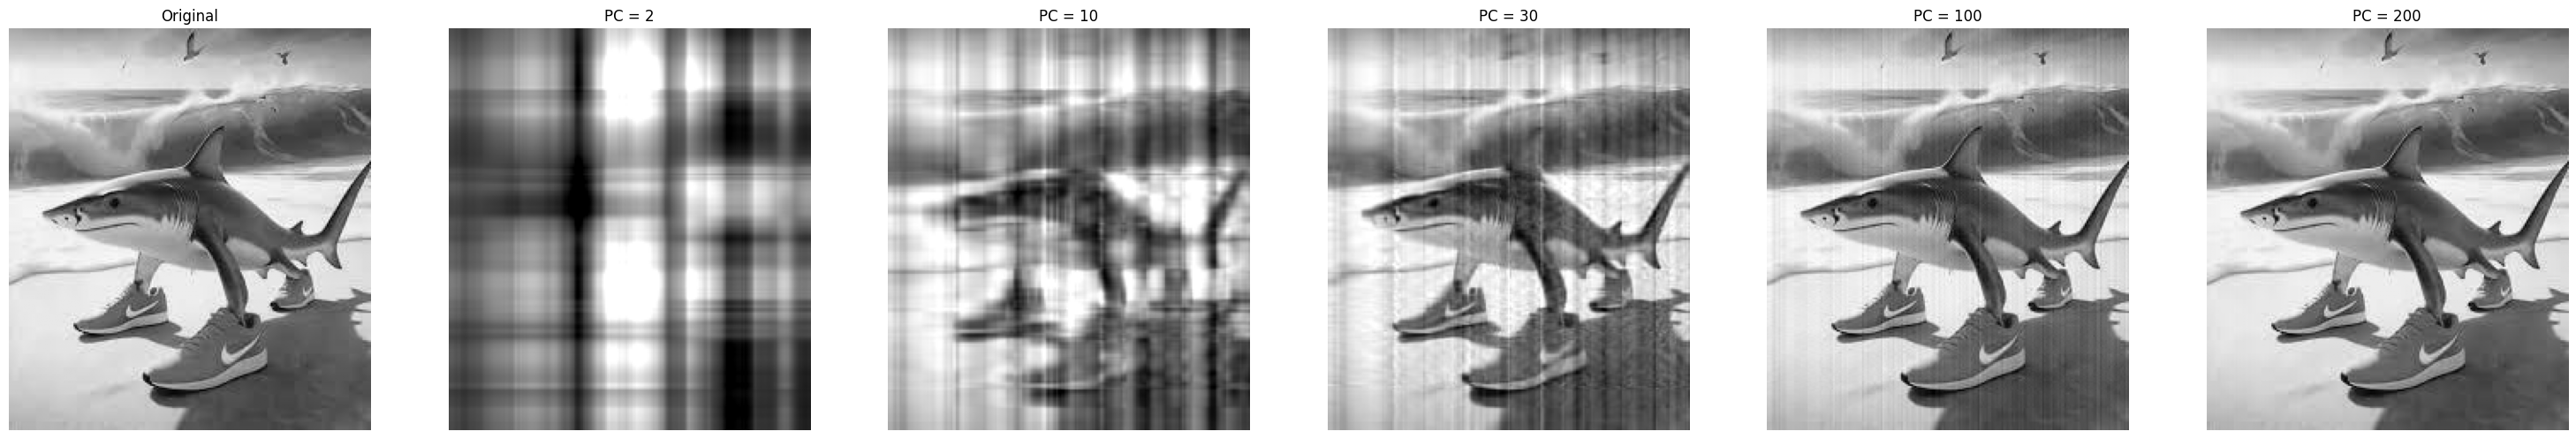

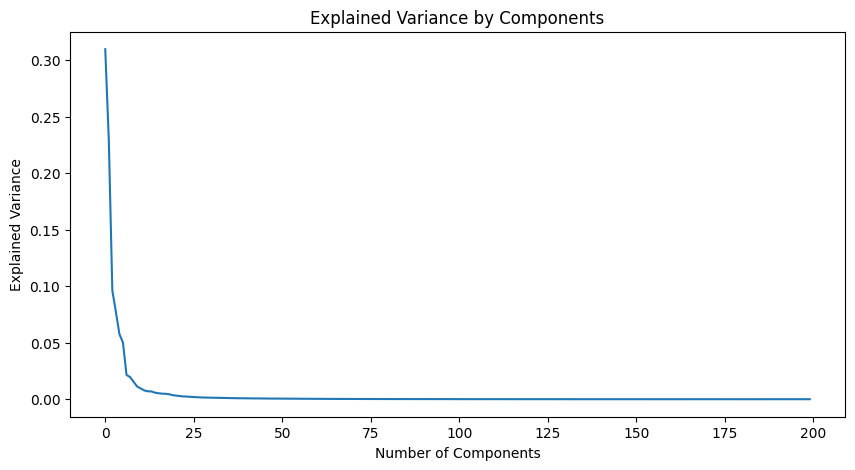

In [52]:
yout_img_path = '/content/drive/MyDrive/Colab Notebooks/DSL/HW/tralla.jpg'  # 실제 경로로 변경
your_components_list = [2, 10, 30, 100, 200]

ev = plot_pca_recon(img_path = yout_img_path, components_list = your_components_list)

plt.figure(figsize = (10, 5))
plt.plot(ev)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

# 4-2. Denoising via PCA

In [53]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA

# 이미지는 16 x 16 크기의 흑백 이미지입니다.
X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

In [55]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(4, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=12)

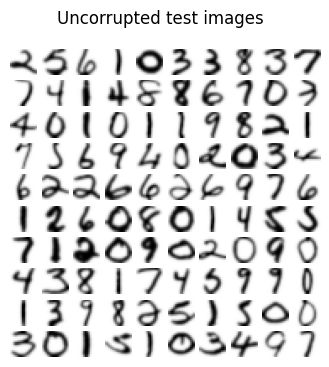

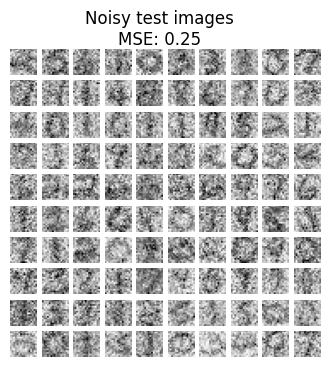

In [56]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

**PCA와 KPCA의 하이퍼파라미터를 적절히 조정하여 MSE(Reconstruction error)를 0.03이하로 만들어보세요!**

In [65]:
pca = PCA(n_components=10, random_state=42)

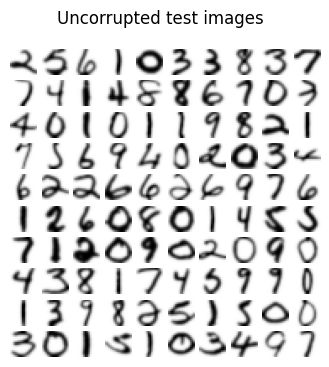

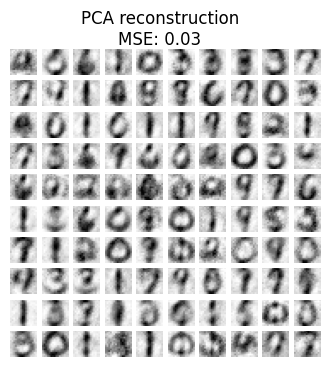

In [66]:
pca.fit(X_train_noisy)

X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)

**주성분 개수(n_components)를 바꿔가며 출력해보았을 때,**

**노이즈 및 복원된 이미지와 어떤 관계를 갖는지 분석해보고 그 이유와 함께 아래에 작성해주세요!**

**(직접 주성분 개수를 증가, 반복시키며 plot하는 코드를 짜서 분석해도 좋습니다~)**

### **Analysis**


주성분 개수가 적을 때는(n=10), 노이즈는 효과적으로 제거되지만, 이미지의 중요한 디테일까지 함께 소실되어 전체적으로 매우 흐릿한 이미지가 복원됨. 왜냐하면 이미지의 핵심적인 특징을 표현하기에 주성분이 너무 부족하여 정보 손실이 크기 때문.

주성분 개수가 많을 때는(n=200), 이미지는 선명해지지만, 제거하려던 노이즈가 상당 부분 그대로 복원됨. 왜냐하면 노이즈에 해당하는 분산이 작은 주성분들까지 복원에 사용하여, 노이즈를 데이터의 일부 특징으로 인식하고 다시 만들어내기 때문.

주성분 개수가 적절할 때는(n=40), 노이즈는 대부분 제거되면서도, 원본 이미지의 주요 특징은 선명하게 유지되는 가장 이상적인 이미지가 복원됨. 왜냐하면 신호를 담고 있는 상위 주성분은 대부분 포함하고, 노이즈를 담고 있는 하위 주성분은 대부분 버리는 최적의 지점을 찾았기 때문.